## Information on the lending club
* lending club is a US p2p lending company in San Francisco, California
* borrowers apply for loans, borrowers get funded, and repay automatically
* investors open an account, build a portfolio, then earn and reinvest


## Basic Libraries and Configurations

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import lightgbm as lgb
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import re
import statistics
pd.options.display.max_rows = 1000

## Code to read csv file into Colaboratory

In [0]:
### Authenticate and create the PyDrive client
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Obtain sharable link from Google Drive

In [0]:
link = 'https://drive.google.com/open?id=18z2W5cxydH3KjAfMkEgoWJTP9b_ER61X'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '=' 

18z2W5cxydH3KjAfMkEgoWJTP9b_ER61X


###  Get google drive file into dataframe

In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('accepted_2007_to_2018Q4.csv')  
df_download = pd.read_csv('accepted_2007_to_2018Q4.csv', na_values = ["", "n/a", "NaN"])


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
df = df_download


## Creation of functions


some considerations for removing null values and removing less useful columns
1. clean up the column names and column entries, i.e. remove trailing or leading spaces
2. remove columns that only has one entry
3. find all missing values
4. if there are very little non-null values, then we should remove them (threshold of 90%)
5. for the variables that are categorical, how many of them have few number of unique values for one-hot encoding
6. do one-hot encoding
7. check for correlation, i.e. remove the columns that are closely correlated
8. check for outliers
9. count categorical variables
10. view value counts for identified categorical variables

In [0]:
# Function 1
## Insert description of function
def clean_up(df):
    # remove trailing or leading spaces in column names
    cleaned_colnames = [''.join(word.strip()) for word in df.columns.values]
    df.columns = cleaned_colnames
    # remove trailing or leading spaces in column entries (apply for categorical variables)
    for name in df.columns:
        if df[name].dtype == 'object':
            df[name] = df[name].str.strip()
   
    return df

# Function 2
## Insert description of function
def corr_heatmap(df, n, annot_switch = False):  # for annot_switch, determine yes / no
	correlations = df.corr()
	cmap = sns.diverging_palette(220, 10, as_cmap = True)
		
	fig, ax = plt.subplots(figsize = (n,n))  # adjust plotsize here
	sns.heatmap(correlations, cmap = cmap, vmax = 1.0,
			    center = 0, fmt = '.2f', square = True,
				linewidth = 0.5, annot = annot_switch, cbar_kws = {'shrink': .75})

	plt.show()
 
# Function 3
## Insert description of function
def split_cat_num(df):
	catvar = []
	for name in df.columns:
		if df[name].dtype == 'object':
			catvar.append(name)

	df_catvar = df.loc[:, catvar]		
	df_numvar = df.drop(catvar, axis = 1)

	return df_catvar, df_numvar

# Function 4
## Insert description of function
def define_y(df, y_var, y_var_0, y_var_1):
    series = df[y_var]
    target_values = []
    for entry in series.values:
        if entry in y_var_1: target_values.append(1)
        elif entry in y_var_0: target_values.append(0)
        else: target_values.append(-1)

    df['target'] = target_values
    df.target.astype(np.int)
    df.target.replace(-1, np.nan, inplace = True)

# Function 5
## To perform principal component analysis. INPUT: numerical variables and no. of components desired. OUTPUT: principal components
def do_pca(train_feature_num_stscale, test_feature_num_stscale, n_comp):

    pca_train = PCA(n_components = n_comp).fit(train_feature_num_stscale)
    pca_test = PCA(n_components = n_comp).fit(test_feature_num_stscale)

    X_train_pca = pca_train.transform(train_feature_num_stscale)
    X_test_pca = pca_test.transform(test_feature_num_stscale)

    return (X_train_pca, X_test_pca)

# Function 6
## Simple logistic regression. INPUT: Train and test features and target. OUTPUT: predict (1/0), predict_prob, train and test accuracy score
def do_logReg(X_train, X_test, train_target, test_target):

    model = LogisticRegression(solver = 'lbfgs')  # we use a faster solver instead of the default
    model.fit(X_train, train_target)
    
    # Predicting the target
    predict_train = model.predict(X_train)
    predict_test = model.predict(X_test)
    predict_test_prob = model.predict_proba(X_test)
    
    # Accuracy scores on training and test predictions
    train_accuracy_score = accuracy_score(train_target, predict_train)
    test_accuracy_score = accuracy_score(test_target, predict_test)

    return  predict_test, predict_test_prob, train_accuracy_score, test_accuracy_score

# Function 7
## Simple tree using default parameters. INPUT: Train and test features and target. OUTPUT: predict (1/0), predict_prob, train and test accuracy score
def tree(train_feature, train_target, test_feature, test_target):
    classifier=DecisionTreeClassifier()
    classifier.fit(train_feature, train_target)
    
    #Predicting the target
    test_predictions = classifier.predict(test_feature)
    train_predictions = classifier.predict(train_feature)
    test_proba = classifier.predict_proba(test_feature)
    train_proba = classifier.predict_proba(train_feature)
    
    # Accuracy scores on training and test predictions
    train_accuracy_score = accuracy_score(train_predictions, train_target)
    test_accuracy_score = accuracy_score(test_predictions, test_target)
   
    return  test_predictions, test_proba, train_accuracy_score, test_accuracy_score

# Function 8
## Random Forest with specified parameters. INPUT: Train and test features and target. OUTPUT: predict (1/0), predict_prob, train and test accuracy score
def rf (train_feature, train_target, test_feature, test_target):
    classifier = RandomForestClassifier(max_features = 8, random_state = 0, n_jobs = -1)
    classifier.fit(train_feature, train_target)

    # Predicting the target
    test_predictions = classifier.predict(test_feature)
    train_predictions = classifier.predict(train_feature)
    test_proba = classifier.predict_proba(test_feature)
    train_proba = classifier.predict_proba(train_feature)

    # Accuracy scores on training and test predictions
    train_accuracy_score = accuracy_score(train_predictions, train_target)
    test_accuracy_score = accuracy_score(test_predictions, test_target)
  
    return  test_predictions, test_proba, train_accuracy_score, test_accuracy_score

# Function 9
## XGBoost with specified parameters. INPUT: Train and test features and target. OUTPUT: predict (1/0), predict_prob, train and test accuracy score
def XGBoost(train_feature, train_target, test_feature, test_target):
    classifier = XGBClassifier(max_depth = 3, learning_rate = 0.1, n_estimators = 100)
    classifier.fit(train_feature, train_target)
    
    #Predicting the target
    test_predictions = classifier.predict(test_feature)
    train_predictions = classifier.predict(train_feature)
    test_proba = classifier.predict_proba(test_feature)
    train_proba = classifier.predict_proba(train_feature)
    
    # Accuracy scores on training and test predictions
    train_accuracy_score = accuracy_score(train_predictions, train_target)
    test_accuracy_score = accuracy_score(test_predictions, test_target)
   
    return  test_predictions, test_proba, train_accuracy_score, test_accuracy_score

# Function 10
## Light GBM with default parameters. INPUT: Train and test features and target. OUTPUT: predict (1/0), predict_prob, train and test accuracy score
def light_gbm(train_feature, train_target, test_feature, test_target):
    
    # Build LightGBM classifier
    model = lgb.LGBMClassifier()

    # Fit the model with training data
    model.fit(train_feature,train_target)
    
    #Predicting the target
    predict_train = model.predict(train_feature)
    predict_test = model.predict(test_feature)
    test_proba = model.predict_proba(test_feature)
    
    # Accuracy scores on training and test predictions
    train_accuracy_score = accuracy_score(train_target,predict_train)
    test_accuracy_score = accuracy_score(test_target,predict_test)
   
    return  predict_test, test_proba, train_accuracy_score, test_accuracy_score

# Function 11
## Variable-importance plot for random-forest, using same parameters as Function 7. INPUT: Train features and target. OUTPUT: Plot with labels
def variable_importance (train_feature, train_target):
    classifier = RandomForestClassifier(max_features = 8, random_state = 0, n_jobs = -1)
    classifier.fit(train_feature, train_target)
    varimp_rf = classifier.feature_importances_[0:20,:]
    indices_rf = np.argsort(varimp_rf)
    features_rf = train_feature.columns[0:20]

    plt.figure(figsize = (15,15))
    plt.barh(range(len(indices_rf)), varimp_rf[indices_rf])
    plt.yticks(range(len(indices_rf)), features_rf[indices_rf])
    plt.show()

# Function 12
## Ensemble using simple averaging of three selected models. 
def ensemble_avg (predict_proba_1, predict_proba_2, predict_proba_3, test_target):
    avg_proba = (predict_proba_1 + predict_proba_2 + predict_proba_3)/3
    avg_predict = np.int_(np.round(avg_proba[:,1],decimals = 0)).flatten()
    test_accuracy_score = accuracy_score(test_target,avg_predict)

    return avg_predict, avg_proba, test_accuracy_score

## Ensemble using max vote of three selected models. 
def max_vote(pred1,pred2,pred3, target):
    final_predict = np.array([])
    for i in range(0,len(target)):
        final_predict = np.append(final_predict, statistics.mode([pred1[i],pred2[i],pred3[i]]))
        
    test_accuracy_score = accuracy_score(target,final_predict)
    return final_predict, test_accuracy_score
  
# Function 13
#===   Create a function to do reverse one-hot encoding, for purpose of plotting graphs
def reverse_onehot(df, name_to_match, target_name):
			
	adjusted_name_to_match = name_to_match + '_'
	colnames = df.columns.values	
	
	matched_names = []
	for name in colnames:
		if adjusted_name_to_match in name:
			matched_names.append(name)

	sub_df = df.loc[:, matched_names + target_name + ['target']]
				
	# initialise a new dataframe column with all zeroes
	sub_df[name_to_match] = 0
	
	# proceed to do reverse onehot encoding
	for i in range(len(matched_names)): 
		for j in range(len(sub_df)):
			if sub_df.iloc[j,i] == 1:
				sub_df.iloc[j,len(sub_df.columns) - 1] = sub_df.columns[i]
		
	new_df = sub_df.drop(matched_names, axis = 'columns')

	return  new_df	

## Data Exploring Processing Cleaning and Feature Engineering

count     2190392.0
unique        786.0
top           144.0
freq        13787.0
Name: mths_since_last_approved_facility, dtype: float64
0.2    124
0.4    157
0.6    196
0.8    258
Name: mths_since_last_approved_facility, dtype: object


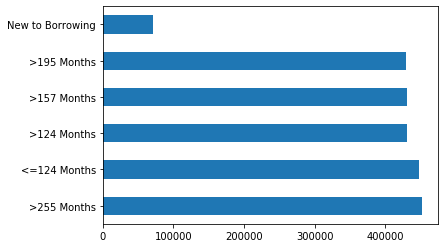

In [0]:
########## 1. Description Dummy Variable ##########
#The idea is that if an applicant is too lazy to even key in the description, it's an indicator of bad credit
# Completion of 'description' in qualitative field 

df['desc'].fillna('blank', inplace = True)
df.loc[df.desc == 'blank', 'desc_blank'] = 'blank' 
df.loc[df.desc != 'blank', 'desc_blank'] = 'filled'

########## 2. Obligor Annual Income ##########
#If there are more than one borrowers, I want to aggregate their income. 
#The rationale is that we should be treating such cases under one obligor group.
#If they pay, they pay together. If they default, they default together. One Obligor Group.

df['annual_inc_joint'].fillna('blank', inplace = True)
df.loc[df.annual_inc_joint == 'blank', 'annual_inc_obligor'] = df.annual_inc
df.loc[df.annual_inc_joint != 'blank', 'annual_inc_obligor'] = df.annual_inc_joint


########## 3. Obligor DTI ##########
#Similarly, we take dti_joint

df['dti_joint'].fillna('blank', inplace = True)
df.loc[df.dti_joint == 'blank', 'dti_obligor'] = df.dti
df.loc[df.dti_joint != 'blank', 'dti_obligor'] = df.dti_joint

########## 4. GCO Within 12 Mths ##########
#For chargeoff_within_12_mths I do not really care about the value, I just want to know if the applicant had any instances.
#So it becomes a binary value, chargeoff within 12 mths = Bad, otherwise good
df['chargeoff_L12M_flag'] = np.where(df['chargeoff_within_12_mths']>0, "Acc Charged Off in L12M", "No Acc Charged Off in L12M")

########## 5. Length of Borrowing Relationship ##########
#I want to know how long the applicant has had a borrowing relationship with a finacial institution
#A longer duration indicates that the applicant knows how to manage monthly installments/revolving credit
#IMPORTANT: A totally new-to-borrowing customer has a high chance of turning NPL, so we need to cater for a special set of null values
def label_mths_since_first_app (row):
    if np.isnan(row['mo_sin_old_il_acct']) == True and np.isnan(row['mo_sin_old_rev_tl_op']) == True:
        return 'New to Borrowing'
    elif np.isnan(row['mo_sin_old_il_acct']) == True:
        return row['mo_sin_old_rev_tl_op']
    elif np.isnan(row['mo_sin_old_rev_tl_op']) == True:
        return row['mo_sin_old_il_acct']
    elif row['mo_sin_old_il_acct'] > row['mo_sin_old_rev_tl_op']:
        return row['mo_sin_old_il_acct']
    return row['mo_sin_old_rev_tl_op']

df['mths_since_last_approved_facility'] = df.apply (lambda row: label_mths_since_first_app(row), axis=1)

#But we cannot leave this column as a mix of String ('New to Borrowing') and Int (Mths since last approved facility)
#Let's take care of this by creating bins of roughly equal amount of 'Mths since last approved facility'

#First, we determine our bins (using roughly the same number of accounts)
test_df = df.loc[df['mths_since_last_approved_facility'] != 'New to Borrowing']
print(test_df['mths_since_last_approved_facility'].describe())
print(test_df.mths_since_last_approved_facility.quantile([0.2,0.4,0.6,0.8]))

#Now we sort them into bins
def binning_mths (row):
    if row['mths_since_last_approved_facility'] == 'New to Borrowing':
        return 'New to Borrowing'
    elif row['mths_since_last_approved_facility'] > 255:
        return '>255 Months'
    elif row['mths_since_last_approved_facility'] > 195:
        return '>195 Months'
    elif row['mths_since_last_approved_facility'] > 157:
        return '>157 Months'
    elif row['mths_since_last_approved_facility'] > 124:
        return '>124 Months'
    return '<=124 Months'                                     

#Now we apply our formula
df['mths_since_last_approved_facility'] = df.apply (lambda row: binning_mths(row), axis=1)

#Lastly, we check our output to see if we have the right distribution
df['mths_since_last_approved_facility'].value_counts()[:20].plot(kind='barh')

########## Cleaning: Reindexing ##########
#After all of the above, let's reindex our columns
#columns = list(df.columns) 
#df = df.reindex(columns=columns)

## Define Y Variable and remove rows where target Y is NaN



In [0]:
y_var = ['loan_status']
y_var_0 = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']
y_var_1 = ['Charged Off', 'Late (31-120 days)', 'Default', 
					    'Does not meet the credit policy. Status:Charged Off']

In [0]:
define_y(df, y_var, y_var_0, y_var_1)
print("Data shape before dropping NA in target variable", df.shape)

Data shape before dropping NA in target variable (2260701, 157)


In [0]:
# Check for blank spaces and replace with NaNs

df.dropna(subset=['target'], axis=0, inplace=True)

In [0]:
print("Check target variable")
print(df['target'].value_counts())
print("Data shape after dropping NA in target variable", df.shape)

Check target variable
0.0    1078739
1.0     290827
Name: target, dtype: int64
Data shape after dropping NA in target variable (1369566, 157)


## Select and Process Categorical / Numeric Variables

### Split Cat Num

In [0]:
# Split Cat Num
df_catvar, df_numvar = split_cat_num(df)

In [0]:
df_catvar.shape, df_numvar.shape

((1369566, 45), (1369566, 112))

### Select Numeric Variables
*drop unnecessary numeric variables that are not available at onboarding*

In [0]:
#First, we drop 'target' which is the dependent variable
#We also want to drop the following variables because we have engineered features to replace them (above):
#mo_sin_old_il_acct, mo_sin_old_rev_tl_op, dti, annual_inc
numvar_to_drop = ['target', 'member_id', 'acc_now_delinq', 'collection_recovery_fee', 'funded_amnt',
                  'funded_amnt_inv', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt',
                  'num_tl_120dpd_2m', 'num_tl_30dpd', 'out_prncp', 'out_prncp_inv', 'recoveries', 'total_pymnt',
                  'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'settlement_amount',
                  'settlement_percentage', 'settlement_term', 'int_rate','mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'dti', 'annual_inc']

df_num = df_numvar.drop(numvar_to_drop, axis = 1)

print("Data shape of numerical variables", df_num.shape)

KeyError: ignored

### Select Categorical Variables and OHE
*select relevant categorical variables available at onboarding*

In [0]:
# One hot encoder
catselect =['term', 'emp_length', 'home_ownership', 'verification_status', 'desc_blank', 
            'purpose', 'addr_state', 'application_type', 'hardship_flag', 
            'hardship_type', 'hardship_reason', 'hardship_status', 'hardship_loan_status', 
            'disbursement_method','chargeoff_L12M_flag','mths_since_last_approved_facility']
df_cat = df[catselect]
df_cat.info()
df_cat_ohe = pd.get_dummies(df_cat, prefix=catselect, prefix_sep='_', drop_first=False)

print("Data shape of categorical variables before one hot encoding", df_cat.shape)
print("Data shape of categorical variables after one hot encoding",df_cat_ohe.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1369566 entries, 0 to 2260697
Data columns (total 16 columns):
term                                 1369566 non-null object
emp_length                           1289165 non-null object
home_ownership                       1369566 non-null object
verification_status                  1369566 non-null object
desc_blank                           1369566 non-null object
purpose                              1369566 non-null object
addr_state                           1369566 non-null object
application_type                     1369566 non-null object
hardship_flag                        1369566 non-null object
hardship_type                        7379 non-null object
hardship_reason                      7379 non-null object
hardship_status                      7379 non-null object
hardship_loan_status                 7379 non-null object
disbursement_method                  1369566 non-null object
chargeoff_L12M_flag                  1369566 

### Merge Cat Num

In [0]:
# Merge DataFrames use pd.merge instead of pd.concat to preserve index

df_new = pd.merge(df_num, df_cat_ohe, left_index=True, right_index=True)
df_new = pd.merge(df_new, df_numvar['target'], left_index=True, right_index=True)

# Clean column headers
df_new = clean_up(df_new)
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df_new.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df_new.columns.values]

print("Data shape of merged dataframes", df_new.shape)

Data shape of merged dataframes (1369566, 211)


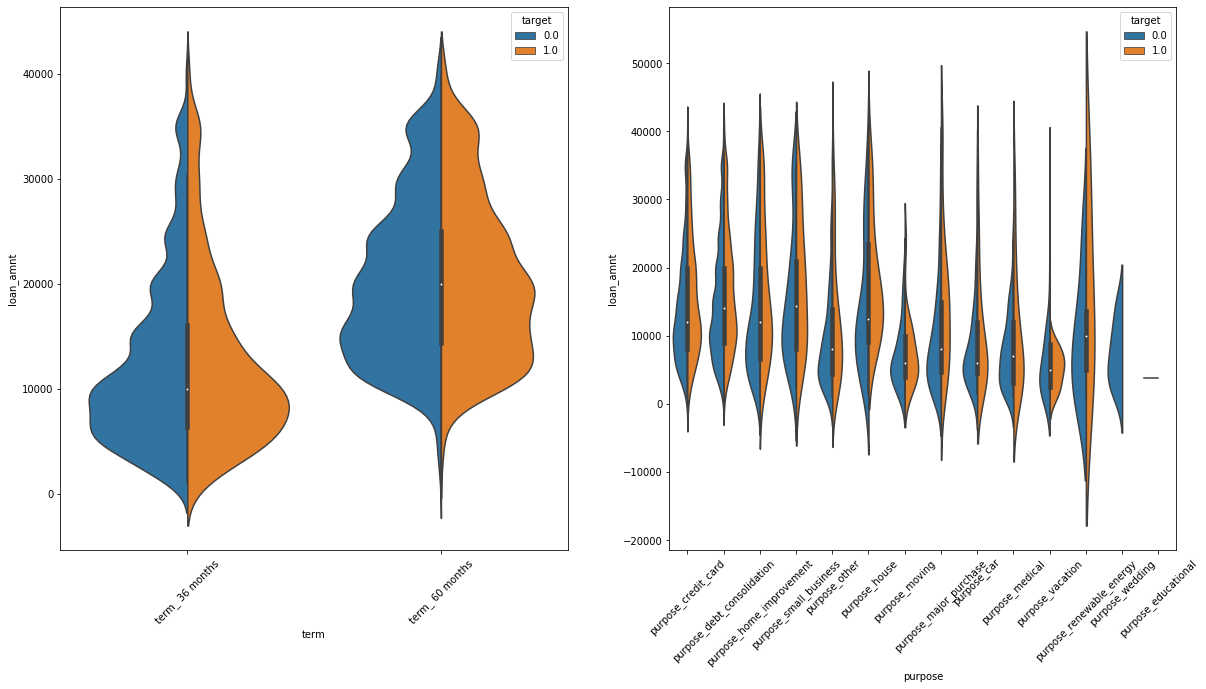

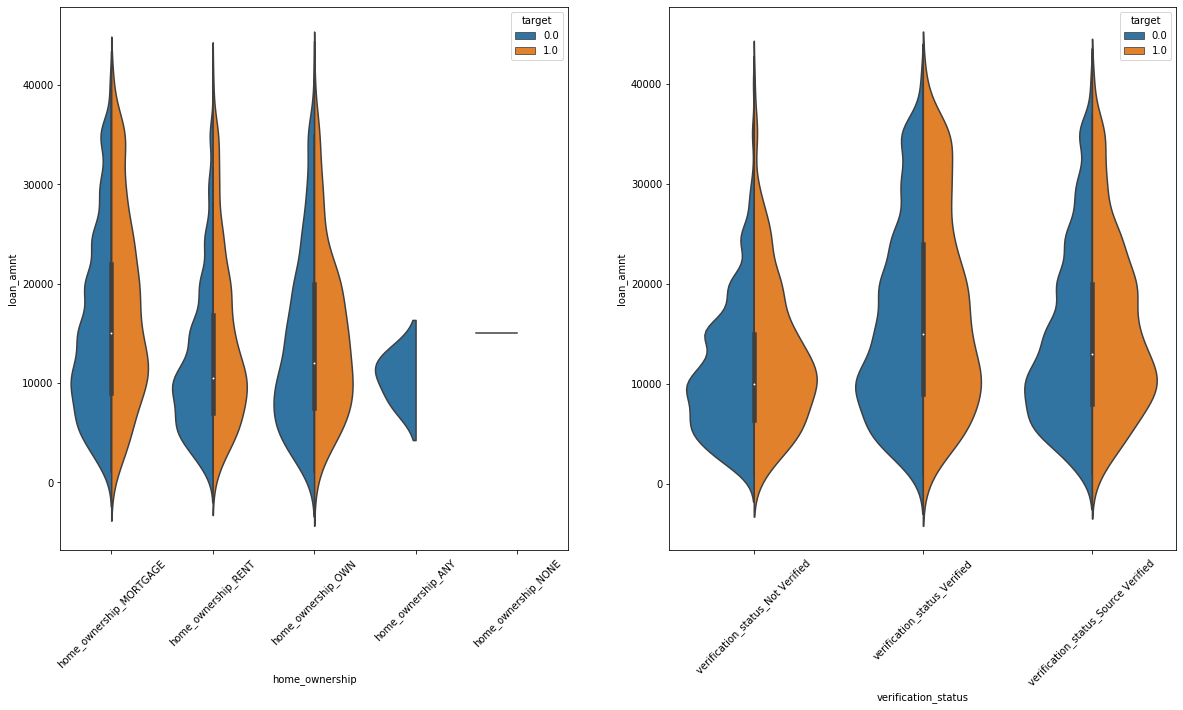

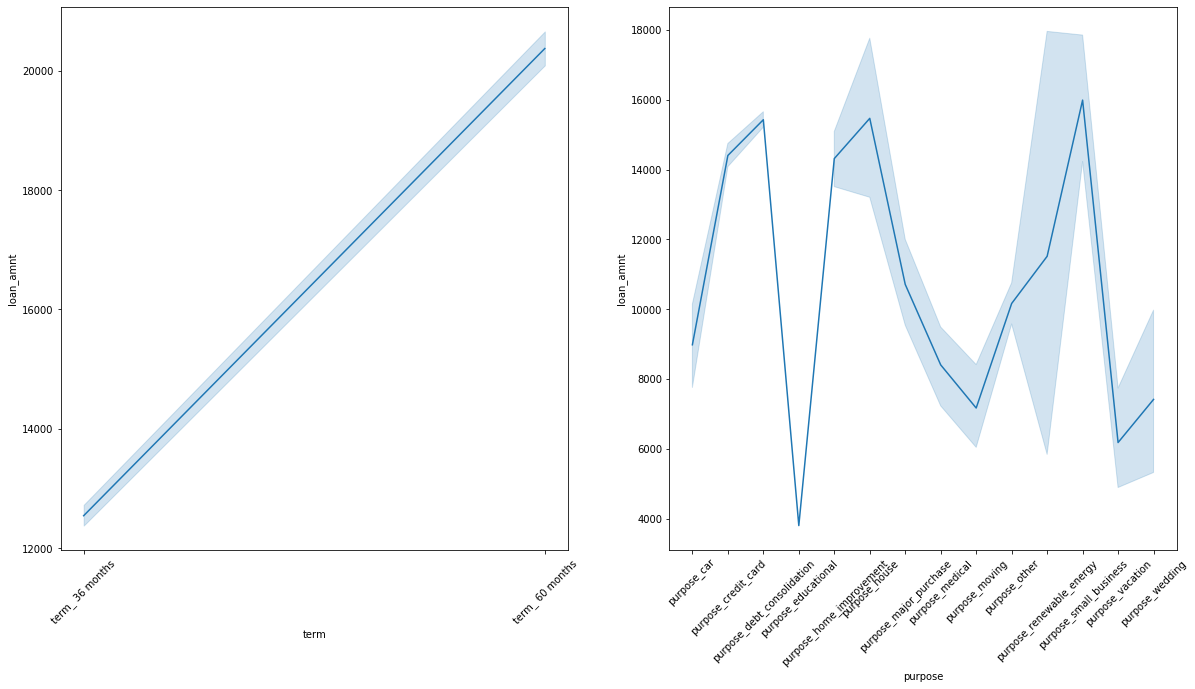

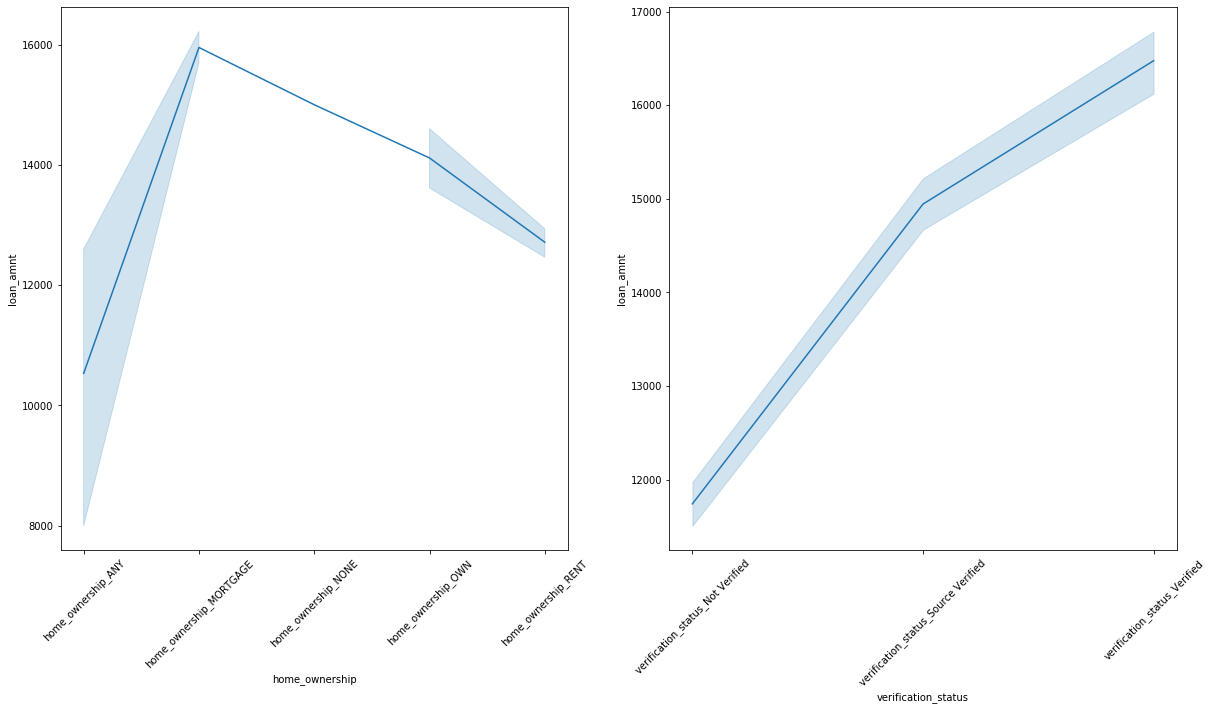

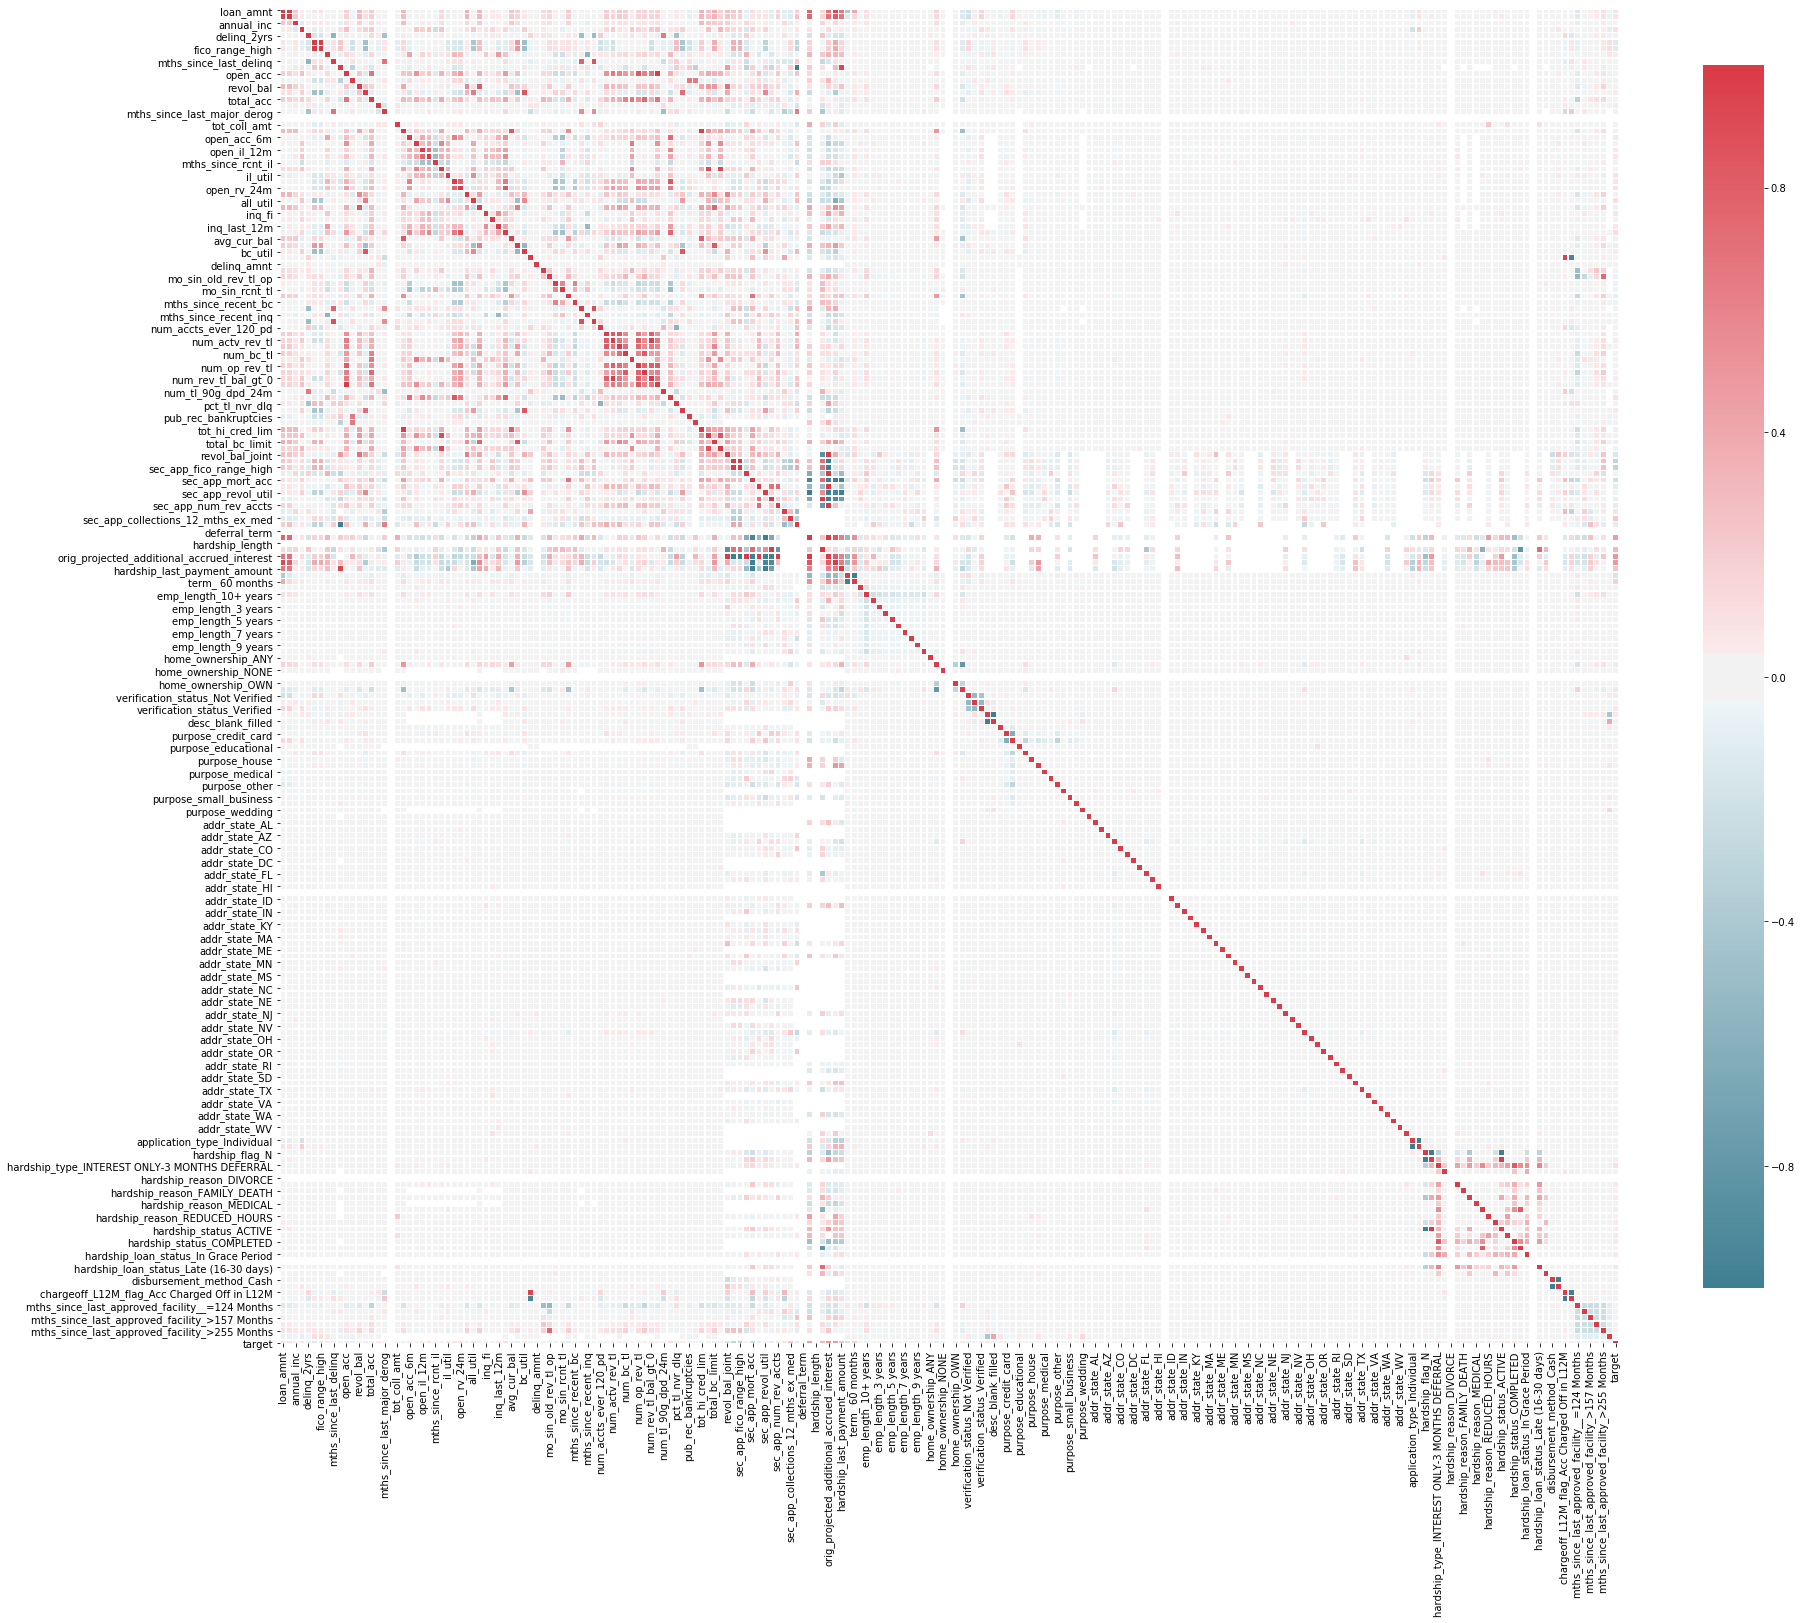

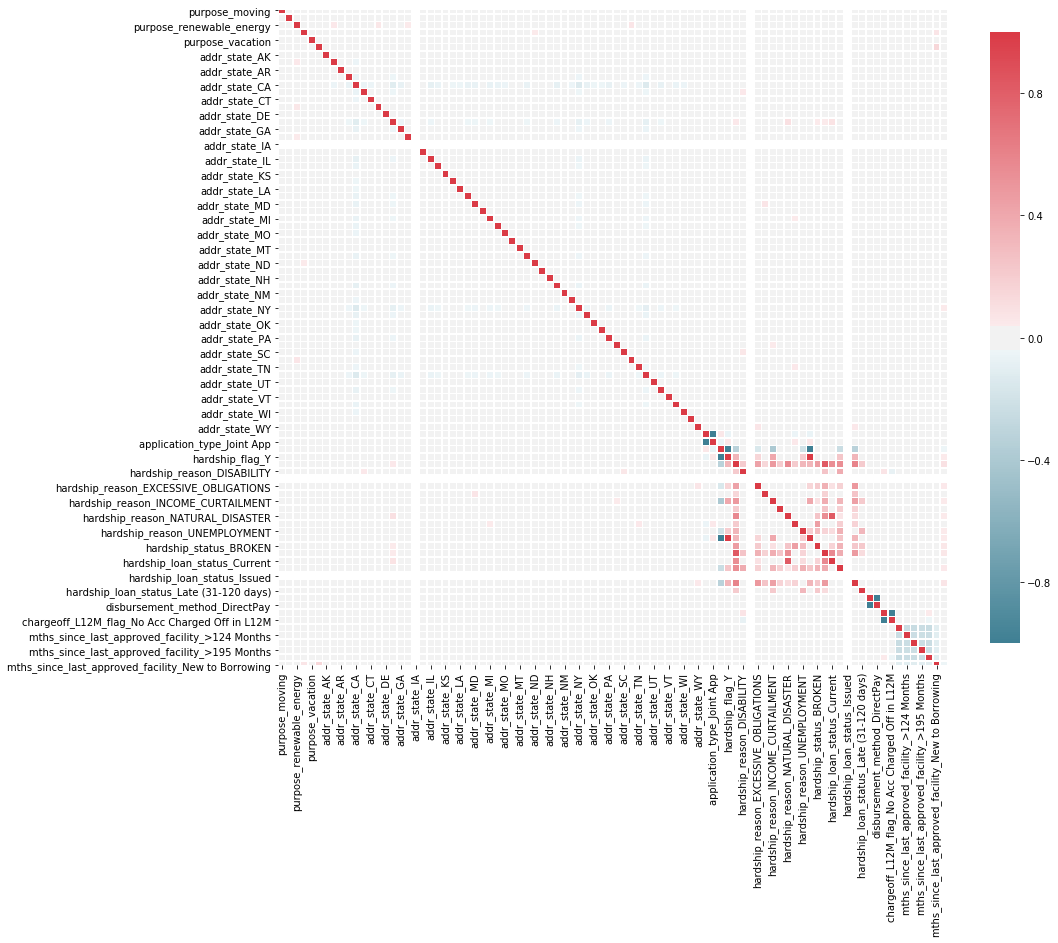

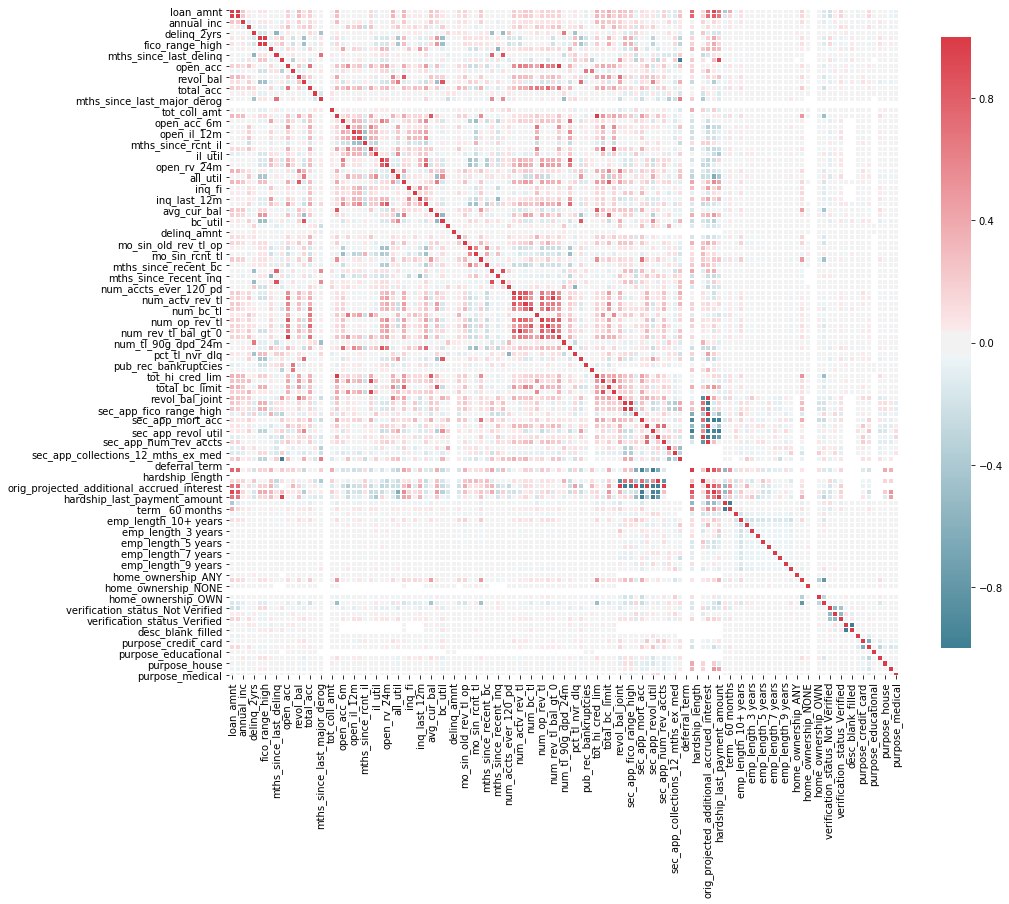

In [0]:
#===   we prepare some dataframes to do some basic plots
name_to_match = ['term','purpose','home_ownership','verification_status']
target_name = 'loan_amnt'

df_forplot = df_new.sample(n = 10000)

# create a list of dataframes
df_list = []
for name in name_to_match:		
	df_list.append(reverse_onehot(df_forplot, name, [target_name]))

# do violinplots (1)
n = 2; m = 1#m = int(len(name_to_match) / n)	
fig, ax = plt.subplots(m, n, figsize = (20, 10))		
sns.violinplot(name_to_match[0], target_name, data = df_list[0], hue = 'target', split = True, ax = ax[0])
sns.violinplot(name_to_match[1], target_name, data = df_list[1], hue = 'target', split = True, ax = ax[1])
plt.sca(ax[0]); plt.xticks(rotation = 45)  # xtick labels configurations
plt.sca(ax[1]); plt.xticks(rotation = 45)  # xtick labels configurations
plt.show()


# do violinplots (2)
n = 2; m = 1#m = int(len(name_to_match) / n)	
fig, ax = plt.subplots(m, n, figsize = (20, 10))		
sns.violinplot(name_to_match[2], target_name, data = df_list[2], hue = 'target', split = True, ax = ax[0])
sns.violinplot(name_to_match[3], target_name, data = df_list[3], hue = 'target', split = True, ax = ax[1])
plt.sca(ax[0]); plt.xticks(rotation = 45)  # xtick labels configurations
plt.sca(ax[1]); plt.xticks(rotation = 45)  # xtick labels configurations
plt.show()


# do lineplots (1)
fig, ax = plt.subplots(m, n, figsize = (20,10))
sns.lineplot(name_to_match[0], target_name, data = df_list[0], ax = ax[0])
sns.lineplot(name_to_match[1], target_name, data = df_list[1], ax = ax[1])
plt.sca(ax[1]); plt.xticks(rotation = 45)  # xtick labels configurations
plt.sca(ax[0]); plt.xticks(rotation = 45)  # xtick labels configurations
plt.show()

# do lineplots (2)
fig, ax = plt.subplots(m, n, figsize = (20,10))
sns.lineplot(name_to_match[2], target_name, data = df_list[2], ax = ax[0])
sns.lineplot(name_to_match[3], target_name, data = df_list[3], ax = ax[1])
plt.sca(ax[0]); plt.xticks(rotation = 45)  # xtick labels configurations
plt.sca(ax[1]); plt.xticks(rotation = 45)  # xtick labels configurations
plt.show()

#===   correlation heatmaps
# output number of OHE columns (note that the corr_heatmap function has been changed)
num_onehot_cols = df_cat_ohe.shape[1]  # find out the number of OHE columns

corr_heatmap(df_forplot, 30, False)  # corr plots for all columns, too much details!!
corr_heatmap(df_forplot.iloc[:,num_onehot_cols:], 15, False) # corr plots for onehot columns 
corr_heatmap(df_forplot.iloc[:,:num_onehot_cols], 15, False) # corr plots for non onehot columns


## Train Test Split

In [0]:
## Split Train & Test Data into X and Y 

## Y Variable  
all_target = df_new['target'].astype(int)
## X Variable
all_feature = df_new.drop(['target'], axis=1)

## Split Train & Test Data
train_feature, test_feature, train_target, test_target = train_test_split(all_feature, all_target, test_size = 0.2, random_state=42)

print("Data shape for train features", train_feature.shape)
print("Data shape for test features", test_feature.shape)
print("Data shape for train_target",train_target.shape)
print("Data shape for test target",test_target.shape)

Data shape for train features (1095652, 210)
Data shape for test features (273914, 210)
Data shape for train_target (1095652,)
Data shape for test target (273914,)


## Numeric Variables - Split Scale Aggregate

Apply scaler after splitting (not before) to prevent data leakage. Consolidate features after splitting and scaling.

In [0]:
# Perform standard scaling
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)

train_feature_num = train_feature[df_num.columns] # Assign numeric variables to object
train_feature_num_stscale = pd.DataFrame(scaler.fit_transform(train_feature_num), columns=train_feature_num.columns, index=train_feature_num.index) # Apply scaler
train_feature_num_stscale.fillna(0, inplace=True) # Treat missing values using mean
train_feature_cat_ohe = train_feature.drop(train_feature_num.columns, axis=1) # Assign categorical OHE variables to object
train_feature_all = pd.merge(train_feature_num_stscale, train_feature_cat_ohe, left_index=True, right_index=True) # Combine scaled num variables with ohe cat variables

test_feature_num = test_feature[df_num.columns]
test_feature_num_stscale = pd.DataFrame(scaler.fit_transform(test_feature_num), columns=test_feature_num.columns, index=test_feature_num.index)
test_feature_num_stscale.fillna(0, inplace=True) # Treat missing values using mean
test_feature_cat_ohe = test_feature.drop(test_feature_num.columns, axis=1)
test_feature_all = pd.merge(test_feature_num_stscale, test_feature_cat_ohe, left_index=True, right_index=True)


Perform PCA

In [0]:
# Perform PCA, note only numerical variables are included here
n_comp = 15
X_train_pca, X_test_pca= do_pca(train_feature_num_stscale, test_feature_num_stscale, n_comp)

print("rows and columns for train data after PCA", X_train_pca.shape)
print("rows and columns for test data after PCA", X_test_pca.shape)

rows and columns for train data after PCA (1095652, 15)
rows and columns for test data after PCA (273914, 15)


Sets of training and test data

In [0]:
# Sets of training and test data
# Set 1 with all features available at onboarding
print("Train all features", train_feature_all.shape)
print("Test all features", test_feature_all.shape)

# Set 2 with only numerical variables after PCA
print("Train numerical features after PCA", X_train_pca.shape)
print("Test numerical features after PCA", X_test_pca.shape)
    
# Target variable
print("Train target variable", train_target.shape)
print("Test target variable", test_target.shape)

Train all features (1095652, 210)
Test all features (273914, 210)
Train numerical features after PCA (1095652, 15)
Test numerical features after PCA (273914, 15)
Train target variable (1095652,)
Test target variable (273914,)


## Set 1: Models using information available upon onboarding


In [0]:
# Logistic regression
logreg_predictions_onboard, logreg_proba_onboard, logreg_train_accuracy_score_onboard, logreg_test_accuracy_score_onboard = do_logReg(train_feature_all, test_feature_all, train_target, test_target)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [0]:
# Apply tree
tree_test_predictions_onboard, tree_proba_onboard, tree_train_accuracy_score_onboard, tree_test_accuracy_score_onboard = tree(train_feature_all,train_target, test_feature_all, test_target)

In [0]:
# Apply random forest
rf_test_predictions_onboard, rf_proba_onboard, rf_train_accuracy_score_onboard, rf_test_accuracy_score_onboard = rf(train_feature_all,train_target, test_feature_all, test_target)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
# Apply XGB
xgb_test_predictions_onboard, xgb_proba_onboard, xgb_train_accuracy_score_onboard, xgb_test_accuracy_score_onboard = XGBoost(train_feature_all,train_target, test_feature_all, test_target)

In [0]:
# Apply light GBM
lightgbm_test_predictions_onboard, lightgbm_proba_onboard, lightgbm_train_accuracy_score_onboard, lightgbm_test_accuracy_score_onboard = light_gbm(train_feature_all,train_target, test_feature_all, test_target)

In [0]:
# Apply ensemble - simple average.
# Select LogReg, Rf, Light GBM - three different types of models
avg_predict_onboard, avg_proba_onboard, avg_test_accuracy_score_onboard = ensemble_avg (logreg_proba_onboard, rf_proba_onboard, lightgbm_proba_onboard, test_target)

In [0]:
# Apply ensemble - max vote
# Select LogReg, Rf, Light GBM - three different type of models
max_vote_predict_onboard, max_vote_accuracy_score_onboard = max_vote(logreg_predictions_onboard,rf_test_predictions_onboard,lightgbm_test_predictions_onboard, test_target)

In [0]:
# Print test accurancy scores
print("Test accuracy score using information available on onboarding as x-var")
print("Logistic Regression test accuracy score: ",  logreg_test_accuracy_score_onboard)
print("Tree test accuracy score: ", tree_test_accuracy_score_onboard)
print("Random Forest test accuracy score: ", rf_test_accuracy_score_onboard)
print("XGBoost test accuracy score: ", xgb_test_accuracy_score_onboard)
print("Light GBM test accuracy score: ", lightgbm_test_accuracy_score_onboard)
print("Simple average ensemble test accuracy score: ", avg_test_accuracy_score_onboard)
print("Max vote ensemble test accuracy score: ", max_vote_accuracy_score_onboard)

In [0]:
variable_importance (train_feature_all,train_target)

## Set 2: Models leveraging PCA


In [0]:
# Logistic regression
logreg_predictions_pca, logreg_proba_pca, logreg_train_accuracy_score_pca, logreg_test_accuracy_score_pca = do_logReg(X_train_pca, X_test_pca, train_target, test_target)

In [0]:
# Apply tree
tree_test_predictions_pca, tree_proba_pca, tree_train_accuracy_score_pca, tree_test_accuracy_score_pca = tree (X_train_pca,train_target, X_test_pca, test_target)

In [0]:
# Apply random forest
rf_test_predictions_pca, rf_proba_pca, rf_train_accuracy_score_pca, rf_test_accuracy_score_pca = rf (X_train_pca,train_target, X_test_pca, test_target)

In [0]:
# Apply XGB
xgb_test_predictions_pca, xgb_proba_pca, xgb_train_accuracy_score_pca, xgb_test_accuracy_score_pca = XGBoost (X_train_pca,train_target, X_test_pca, test_target)

In [0]:
# Apply light GBM
lightgbm_test_predictions_pca, lightgbm_proba_pca, lightgbm_train_accuracy_score_pca, lightgbm_test_accuracy_score_pca = light_gbm(X_train_pca,train_target, X_test_pca, test_target)

In [0]:
# Apply ensemble - simple average.
# Select LogReg, Rf, Light GBM - three different types of models
avg_predict_pca, avg_proba_pca, avg_test_accuracy_score_pca = ensemble_avg (logreg_proba_pca, rf_proba_pca, lightgbm_proba_pca, test_target)

In [0]:
# Compare test accuracy scores
print("Test accuracy score using PCA as x-var")
print("Logistic Regression test accuracy score: ",  logreg_test_accuracy_score_pca)
print("Tree test accuracy score: ", tree_test_accuracy_score_pca)
print("Random Forest test accuracy score: ", rf_test_accuracy_score_pca)
print("XGBoost test accuracy score: ", xgb_test_accuracy_score_pca)
print("Light GBM test accuracy score: ", lightgbm_test_accuracy_score_pca)
print("Simple average ensemble test accuracy score: ", avg_test_accuracy_score_pca)

## Set 3: Models based on business intuition

First, I only keep variables that I want in the df, I will later do some feature engineering, and then finally do a split between cat_var and num_var

In [0]:
selected_var = ['all_util','annual_inc_obligor','application_type','chargeoff_L12M_flag','delinq_2yrs','dti_obligor','emp_length','home_ownership','inq_last_6mths','mths_since_last_approved_facility','open_acc','pub_rec','term','int_rate','tot_coll_amt','hardship_flag','disbursement_method']
df_select = df[selected_var] 

Finally, look at our new df

In [0]:
print(df_select.shape)
df_select.info()

Select Numeric Variables

In [0]:
selected_var_num =['all_util','annual_inc_obligor','delinq_2yrs','dti_obligor','inq_last_6mths','open_acc','pub_rec','tot_coll_amt']
df_select_num = df_select[selected_var_num]
print("Data shape of numerical variables", df_select_num.shape)
df_select_num.info()

Select Categorical Variables

In [0]:
# One hot encoder
selected_var_cat =['application_type','emp_length','home_ownership','term','hardship_flag','disbursement_method','chargeoff_L12M_flag','mths_since_last_approved_facility']
df_select_cat = df_select[selected_var_cat]
df_select_cat.info()
df_select_cat_ohe = pd.get_dummies(df_select_cat, prefix=selected_var_cat, prefix_sep='_', drop_first=False)

print("Data shape of categorical variables before one hot encoding", df_select_cat.shape)
print("Data shape of categorical variables after one hot encoding",df_select_cat_ohe.shape)

Combine Categorical, Numerical, and Target Variables

In [0]:
df_new_select = pd.merge(df_select_num, df_select_cat_ohe, left_index=True, right_index=True)
df_new_select = df_new_select.merge(df['target'].to_frame(), left_index=True, right_index=True)

# Clean column headers
df_new_select = clean_up(df_new_select)
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df_new_select.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df_new_select.columns.values]

print("Data shape of merged dataframes", df_new_select.shape)

#Check Head
df_new_select.head(10)

Train test split

In [0]:
## Split Train & Test Data into X and Y 

## Y Variable  
all_target_new = df_new_select['target'].astype(int)
## X Variable
all_feature_new = df_new_select.drop(['target'], axis=1)

## Split Train & Test Data
train_feature_new, test_feature_new, train_target_new, test_target_new = train_test_split(all_feature_new, all_target_new, test_size = 0.2, random_state=42)

print("Data shape for train features", train_feature_new.shape)
print("Data shape for test features", test_feature_new.shape)
print("Data shape for train_target",train_target_new.shape)
print("Data shape for test target",test_target_new.shape)

Judgemental Model Train-Test Split

In [0]:
# Perform standard scaling
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)

train_feature_num_new = train_feature_new[df_select_num.columns] # Assign numeric variables to object
train_feature_num_stscale_new = pd.DataFrame(scaler.fit_transform(train_feature_num_new), columns=train_feature_num_new.columns, index=train_feature_num_new.index) # Apply scaler
train_feature_num_stscale_new.fillna(0, inplace=True) # Treat missing values
train_feature_cat_ohe_new = train_feature_new.drop(train_feature_num_new.columns, axis=1) # Assign categorical OHE variables to object
train_feature_select = pd.merge(train_feature_num_stscale_new, train_feature_cat_ohe_new, left_index=True, right_index=True) # Combine scaled num variables with ohe cat variables

test_feature_num_new = test_feature_new[df_select_num.columns]
test_feature_num_stscale_new = pd.DataFrame(scaler.fit_transform(test_feature_num_new), columns=test_feature_num_new.columns, index=test_feature_num_new.index)
test_feature_num_stscale_new.fillna(0, inplace=True) # Treat missing values
test_feature_cat_ohe_new = test_feature_new.drop(test_feature_num_new.columns, axis=1)
test_feature_select = pd.merge(test_feature_num_stscale_new, test_feature_cat_ohe_new, left_index=True, right_index=True)

Set 3 data

In [0]:
# Set 3 training and test data
print("Train numerical features after feature selection", train_feature_select.shape)
print("Test numerical features after feature selection", test_feature_select.shape)

Apply Models

In [0]:
# Logistic regression
logreg_predictions_select, logreg_proba_select, logreg_train_accuracy_score_select, logreg_test_accuracy_score_select = do_logReg(train_feature_select, test_feature_select, train_target_new, test_target_new)

In [0]:
# Apply tree
tree_test_predictions_select, tree_proba_select, tree_train_accuracy_score_select, tree_test_accuracy_score_select = tree (train_feature_select,train_target_new, test_feature_select, test_target_new)

In [0]:
# Apply random forest
rf_test_predictions_select, rf_proba_select, rf_train_accuracy_score_select, rf_test_accuracy_score_select = rf (train_feature_select,train_target_new, test_feature_select, test_target_new)

In [0]:
# Apply XGB
xgb_test_predictions_select, xgb_proba_select, xgb_train_accuracy_score_select, xgb_test_accuracy_score_select = XGBoost (train_feature_select,train_target_new, test_feature_select, test_target_new)

In [0]:
# Apply light GBM
lightgbm_test_predictions_select, lightgbm_proba_select, lightgbm_train_accuracy_score_select, lightgbm_test_accuracy_score_select = light_gbm(train_feature_select,train_target_new, test_feature_select, test_target_new)

In [0]:
# Apply ensemble - simple average.
# Select LogReg, Rf, Light GBM - three different types of models
avg_predict_select, avg_proba_select, avg_test_accuracy_score_select = ensemble_avg (logreg_proba_select, rf_proba_select, lightgbm_proba_select, test_target)

In [0]:
# Print test accurancy scores
print("Test accuracy score using information available on onboarding as x-var")
print("Logistic Regression test accuracy score: ",  logreg_test_accuracy_score_select)
print("Tree test accuracy score: ", tree_test_accuracy_score_select)
print("Random Forest test accuracy score: ", rf_test_accuracy_score_select)
print("XGBoost test accuracy score: ", xgb_test_accuracy_score_select)
print("Light GBM test accuracy score: ", lightgbm_test_accuracy_score_select)
print("Simple average ensemble test accuracy score: ", avg_test_accuracy_score_select)

In [0]:
variable_importance (train_feature_select,train_target_new)